# Homework 3  - Part B


###### Roll Number: 20110236

We'll start Part B by taking out a minute to thank creators of Tensorflow and Keras for making our lives easier. The goal of this home work is to design a convolutional neural network to classify images from CIFAR-10. CIFAR-10 is a subset of CIFAR-100 with 10 and 100 being number of classes. They were collected by Alex Krizhevsky, Vinod Nair, and Geoffrey Hinton. We'll be building small CNNs using Keras to solve this classification task.
<br>

Please note:
- You have to save each trained model weights and tensorboard logs in different folder. Use proper names for the model
- You have to show trainings in this notebook file, so make sure that the printings and figures are available on this notebook file
- This notebook is also your report file. So add your comments and analysis of each task. Your comments and analysis are as important as your code. This would be considered short report and it is compulsory part of the homework.
- Your system memory may overflow. In that case, please reset memory for trained model(s) keeping printed logs and history of trained model. History of all trained models could be used to plot the trends.
- For trends you shall also use tensorboard logs 

### Imports

In [2]:
import keras
from keras.models import Model
from keras.layers import Dense, Input, Conv2D, MaxPooling2D, Dropout, Flatten, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger, ReduceLROnPlateau, TensorBoard
from keras.utils import plot_model, to_categorical
import keras.backend as K

from sklearn.model_selection import train_test_split
from IPython.display import display

import cv2
from skimage.io import imread
from skimage.transform import resize

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn')

import os
import glob
your_id = 20100236
np.random.seed(your_id)

Using TensorFlow backend.


In [2]:
import tensorflow as tf
tf.__version__

'1.14.0'

In [3]:
batch_size = 64
num_classes = 10
class_labels = np.arange(0, num_classes, 1)
input_shape_cifar = (32,32,3)
images_dir = './images/cifar/'
epochs = 25
all_histories = []

### Task 1.1   Load dataset information
Download the [CIFAR-10 Dataset](https://drive.google.com/drive/folders/1FPsts3C2tJMVQ1xcCi2XZdb2z_J2OjSr?usp=sharing) and setup your working directory. Be sure to put the dataset in the <code>images_dir</code> directory. We won't be loading images and will only store the file paths in memory. These file paths will be used to load and return batch of images in our generator. Feel free to explore the dataset in this section.

In [4]:
train_dir = images_dir + 'train/'
test_dir = images_dir + 'test/'
label_dir = images_dir + 'labels.txt'

# Use either os.listdir or glob to generate an array of file paths for training and testing data (I would recommend using glob)
train_files = glob.glob(train_dir+'/*.png')
test_files = glob.glob(test_dir+'/*.png')


# Use labels.txt to store labels in an array/dict (NOTE: The line number corresponds to the actual label)
f = open(label_dir,"r")
classes = f.read().splitlines()
f.close()

# Use sci-kit learn's train_test_split method to generate a validation dataset from the training dataset
val_files = train_test_split(train_files, test_size = 0.2, shuffle = True)[1]

In [5]:
train_paths = []
train_labels = []
test_paths = []
test_labels = []

for i in range(len(classes)):
    paths1 = glob.glob(train_dir+'/*'+ classes[i] + '.png') #all the paths of a class 
    train_paths = train_paths + paths1
    train_labels = train_labels + ([i]*len(paths1))
    
    paths2 = glob.glob(test_dir+'/*'+ classes[i] + '.png') #all the paths of a class 
    test_paths = test_paths + paths2
    test_labels = test_labels + ([i]*len(paths2))
    
train_set = pd.DataFrame({'paths' : train_paths, 'labels' : train_labels}) 

test_set = pd.DataFrame({'paths' : test_paths, 'labels' : test_labels}) # <- final test set

#Split the training data intoo train and validation set
X_train, X_val, Y_train, Y_val =  train_test_split(train_set['paths'],train_set['labels'], test_size = 0.2, shuffle = True)

train_set = pd.DataFrame({'paths' : X_train, 'labels' : Y_train}) # <- final training set
val_set = pd.DataFrame({'paths' : X_val, 'labels' : Y_val}) # final validation set


### Task 1.2 Preprocessing
Preprocessing of data such as normalization, mean shift, make the learning task simple for network and could accelerate the training process. 


###### Task 1.2.1 
In images, pixel values range from 0 to 255. To shift the values between (0,1) range, divide input image by 255.

In [6]:
# input is a batch of images of size 32 
# hence images is of size (32,32,32,3)

def preprocessing_norm(images):
    return images/255.0

###### Task 1.2.2
Compute the channel-wise mean and standard deviation (std). Subtract channel-wise mean and divide by channel-wise std. This will shift the mean to zero and variation to 1 for each channel. 

In [7]:
def preprocessing_meanShift(images):
    m = images[0].shape
    ans = np.zeros((m,32,32,3))
    
    means = [np.mean(X[:,:,:,c]) for c in range(3)]
    std = [np.std(X[:,:,:,c]) for c in range(3)]
    
    for i in range(3):
        ans[:,:,:,i] = (images[:,:,:,i]-means[i])/std[i]
    
    return ans

### Task 1.3  Batch Generator
Previously, when training our models, we were loading the complete data in memory to fit our model. However, in practice we're working with very large datasets which cannot be loaded all at once in memory. As a solution, we use "Data Generators" which are essentially python generators that load batches of data from disk into memory and pass into our models. In order to achieve this, we only store filepaths that point to training/test samples in our dataset in memory. A data generator yields a tuple of (Xs,Ys) whenever the generator is used via the next() function. Implementation of a data generator is open ended, you can add whatever arguments you find necessary in addition to the ones provided.

In [8]:
def get_sample(df):
    
    im = cv2.cvtColor(cv2.imread(df['paths']), cv2.COLOR_BGR2RGB)
    
    label = np.zeros((num_classes,), dtype='int')
    label[df['labels']] = 1
    
    return im, label

In [9]:
#directory can be either train_dir or test_dir
def data_generator(df, batch_size = 32, preprocessing = None):
    
    indexes = np.arange(0, len(df), batch_size)
    
    if len(df) % batch_size != 0:
        indexes = indexes[:-1] 
    
    while True: # 1 iteration represents 1 epoch
        np.random.shuffle(indexes) # indexes shuffled for each epoch
        for batch_start in indexes: # 1 iteration represents 1 batch
            batch_examples = df.iloc[batch_start : batch_start+batch_size].reset_index()
            
            # ALTERNATE METHOD - Without placeholders
            batch_imgs = np.array([(get_sample(row))[0] for _,row in batch_examples.iterrows()])
            batch_labels = np.array([(get_sample(row))[1] for _,row in batch_examples.iterrows()])
            
            if preprocessing == None:
                pass
            elif preprocessing == 'Norm':
                batch_imgs = preprocessing_norm(batch_images)
            elif preprocessing == 'meanshift':
                batch_imgs = preprocessing_meanShift(batch_images)
            
            yield batch_imgs,batch_labels
                  

### Task 1.4 Design CNN model
**IMPORTANT**: For each model you create, you need to conduct analysis in a markdown cell below the code cell containing the model's training. Your analysis should include plots, comments on its accuracy/loss, etc. Try to predict images and see what images your model is correctly classifying, see if your model is overfitting or not. For each layer you add, specify its function and then comment on its results.

In [10]:
# Design a CNN to predict classes for the images in the dataset. Try to keep your network shallow since you'll be training your model on your PC as well.
input_img = Input(shape=(input_shape_cifar), name='input_img')

conv1 = Conv2D(8, kernel_size=(3, 3), strides = (2,2),  activation='relu')(input_img)
conv2 = Conv2D(16, (3, 3), strides = (2,2), activation='relu')(conv1)
flat = Flatten()(conv2)
dense1 = Dense(44, activation='relu')(flat)
output_class = Dense(10, activation='softmax')(dense1)


model_initial = Model(inputs=input_img, outputs=output_class)

#### Compile model and plot

In [11]:
model_name = 'base_model'
if not os.path.exists('./'+model_name):
    os.mkdir(model_name)   

In [12]:
 # You may tweak the learning rate
adam = Adam(lr=0.001)

# Use the appropriate loss function and compile the model
model_initial.compile(loss='categorical_crossentropy', 
              optimizer=adam, 
                      
              metrics=['accuracy'])

In [13]:
#plot_model(model_initial, model_name+'/'+model_name+'.png')

In [14]:
model_initial.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_img (InputLayer)       (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 15, 15, 8)         224       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 16)          1168      
_________________________________________________________________
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 44)                34540     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                450       
Total params: 36,382
Trainable params: 36,382
Non-trainable params: 0
_______________________________________________________

#### Task 1.5 Training model
In order to train the model, instead of "model.fit" function, we will use the "model.fit_generator" function for training. For details check out [keras documentation](https://keras.io/models/sequential/)

In [15]:
class LRTensorBoard(TensorBoard):
    def __init__(self, *args, **kwargs):
        super(LRTensorBoard, self).__init__(*args, **kwargs)

    def on_epoch_end(self, epoch, logs=None):
        logs.update({'lr': K.eval(self.model.optimizer.lr)})
        super(LRTensorBoard, self).on_epoch_end(epoch, logs)

In [16]:
# Add the following callbacks to your Model: ModelCheckpoin, CSVLogger, ReduceLROnPlateau. The callback for Tensorboard has already been provided to you.
checkpoint = ModelCheckpoint(model_name+'/'+model_name+'-{epoch:02d}-{val_loss:.2f}.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
csvlogger = CSVLogger(model_name+'/logs.csv', separator=',', append=True)
reducelr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.000001, min_delta=0.03)
tensorboard = LRTensorBoard(log_dir='./'+model_name, histogram_freq=0, write_graph=True, write_grads=1, 
                            batch_size=batch_size, write_images=True)

callbacks = [checkpoint,csvlogger,reducelr, tensorboard]

#### Task 1.5.1 
Train model without using any pre-processing scheme

In [17]:
# Create three generators: For training your model, for validation, for testing.
train_gen = data_generator(train_set, batch_size)
val_gen = data_generator(val_set, batch_size)
test_gen = data_generator(test_set, batch_size)

In [18]:
# Start training your model here
hist_initial = model_initial.fit_generator(train_gen, epochs=epochs, steps_per_epoch=len(Y_train)//batch_size, 
                    validation_data=val_gen, validation_steps=len(Y_val)//batch_size, 
                    callbacks=callbacks, verbose=1)

all_histories.append(hist_initial)




Epoch 1/25
625/625 [==============================] - 31s 49ms/step - loss: 2.6933 - accuracy: 0.2183 - val_loss: 1.7404 - val_accuracy: 0.2999

Epoch 00001: val_loss improved from inf to 1.74041, saving model to base_model/base_model-01-1.74.h5

Epoch 2/25
625/625 [==============================] - 29s 47ms/step - loss: 1.7885 - accuracy: 0.3394 - val_loss: 1.7200 - val_accuracy: 0.3782

Epoch 00002: val_loss improved from 1.74041 to 1.72000, saving model to base_model/base_model-02-1.72.h5
Epoch 3/25
625/625 [==============================] - 30s 48ms/step - loss: 1.5950 - accuracy: 0.4178 - val_loss: 1.5159 - val_accuracy: 0.4262

Epoch 00003: val_loss improved from 1.72000 to 1.51585, saving model to base_model/base_model-03-1.52.h5
Epoch 4/25
625/625 [==============================] - 30s 47ms/step - loss: 1.4670 - accuracy: 0.4683 - val_loss: 1.3809 - val_accuracy: 0.4609

Epoch 00004: val_loss improved from 1.51585 to 1.38085, saving model to base_model/base_model-04-1.38.h5


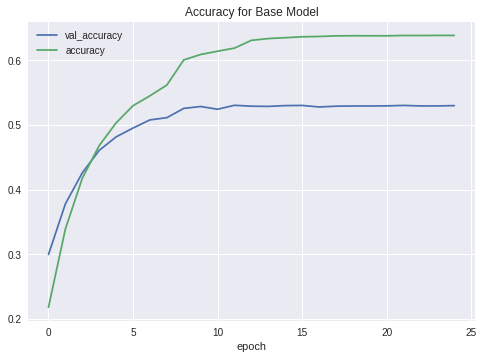

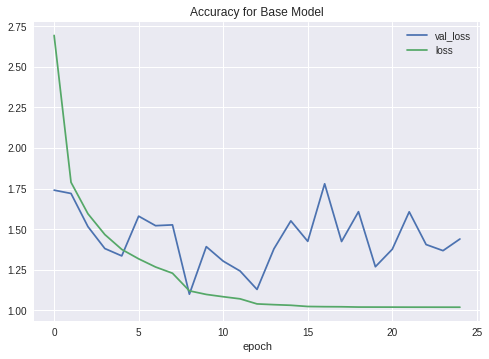

In [164]:
df = pd.read_csv('base_model/logs.csv')
p1 = df.plot(x = 'epoch', y = ['val_accuracy','accuracy'], title = 'Accuracy for Base Model')
p2 = df.plot(x = 'epoch', y = ['val_loss','loss'], title = 'Accuracy for Base Model')

fig = p1.get_figure()
fig.savefig("base_model/pooling_acc.png")

fig = p1.get_figure()
fig.savefig("base_model/pooling_loss.png")

p1
p2

#### Analysis of Base Model
The accuaracy on training set overtakes accuracy in validation set.  
Secondly, loss on the training set has decreased but on validation set it has decreased but after certain epochs it fails to decrease.  
Based on these observations, we can conclude that the base model is clearly **overfit** which means that our model has trained itself best for the training set but it will perform poorly on an unknown example.

#### Task 1.5.2 
Train model by using data preprocessing i.e normalization or mean shift. 

In [20]:
input_img = Input(shape=(input_shape_cifar), name='input_img')

conv1 = Conv2D(8, kernel_size=(3, 3), strides = (2,2),  activation='relu')(input_img)
conv2 = Conv2D(16, (3, 3), strides = (2,2), activation='relu')(conv1)
flat = Flatten()(conv2)
dense1 = Dense(44, activation='relu')(flat)
output_class = Dense(10, activation='softmax')(dense1)

model_preprocessed = Model(inputs=input_img, outputs=output_class)

In [21]:
model_name = 'model_preprocessed_input'

if not os.path.exists('./'+model_name):
    os.mkdir(model_name)
    

In [22]:
# You may tweak this Learning Rate
adam = Adam(lr=0.001)

# Compile your model using an appropriate loss
model_preprocessed.compile(loss='categorical_crossentropy', 
              optimizer=adam, 
              metrics=['accuracy'])

In [23]:
#plot_model(model_preprocessed, model_name+'/'+model_name+'.png')

In [24]:
model_preprocessed.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_img (InputLayer)       (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 8)         224       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 7, 16)          1168      
_________________________________________________________________
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 44)                34540     
_________________________________________________________________
dense_4 (Dense)              (None, 10)                450       
Total params: 36,382
Trainable params: 36,382
Non-trainable params: 0
_______________________________________________________

In [25]:
# Add the following callbacks: ModelCheckpoint, CSVLogger. The callback for tensorboard has been provided to you.
checkpoint = ModelCheckpoint(model_name+'/'+model_name+'-{epoch:02d}-{val_loss:.2f}.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
csvlogger = CSVLogger(model_name+'/logs.csv', separator=',', append=True)
tensorboard = LRTensorBoard(log_dir='./'+model_name, histogram_freq=0, write_graph=True, write_grads=1, 
                            batch_size=batch_size, write_images=True)

callbacks = [checkpoint,csvlogger, tensorboard]

In [26]:
# Create three generators again
train_gen = data_generator(train_set, batch_size)
val_gen = data_generator(val_set, batch_size)
test_gen = data_generator(test_set, batch_size)
x,y= val_gen.__next__()

In [27]:
hist_preprocessed = model_preprocessed.fit_generator(train_gen, 
                    epochs=epochs, 
                    steps_per_epoch=len(Y_train)//batch_size, 
                    validation_data=val_gen, 
                    validation_steps=len(Y_val)/batch_size, 
                    callbacks=callbacks, 
                    verbose=1)

all_histories.append(hist_preprocessed)

Epoch 1/25
625/625 [==============================] - 31s 49ms/step - loss: 2.4794 - accuracy: 0.1025 - val_loss: 2.2809 - val_accuracy: 0.1140

Epoch 00001: val_loss improved from inf to 2.28089, saving model to model_preprocessed_input/model_preprocessed_input-01-2.28.h5
Epoch 2/25
625/625 [==============================] - 30s 47ms/step - loss: 2.0455 - accuracy: 0.2324 - val_loss: 1.9178 - val_accuracy: 0.2956

Epoch 00002: val_loss improved from 2.28089 to 1.91782, saving model to model_preprocessed_input/model_preprocessed_input-02-1.92.h5
Epoch 3/25
625/625 [==============================] - 30s 48ms/step - loss: 1.7622 - accuracy: 0.3428 - val_loss: 1.7990 - val_accuracy: 0.3902

Epoch 00003: val_loss improved from 1.91782 to 1.79903, saving model to model_preprocessed_input/model_preprocessed_input-03-1.80.h5
Epoch 4/25
625/625 [==============================] - 29s 47ms/step - loss: 1.5752 - accuracy: 0.4185 - val_loss: 1.4225 - val_accuracy: 0.4314

Epoch 00004: val_loss imp

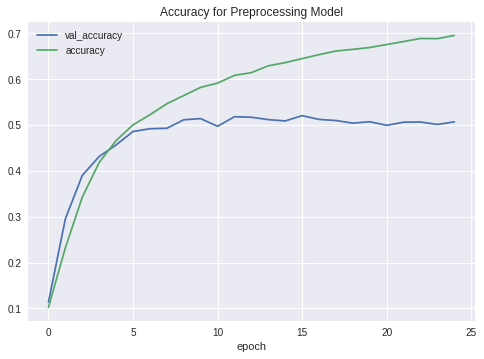

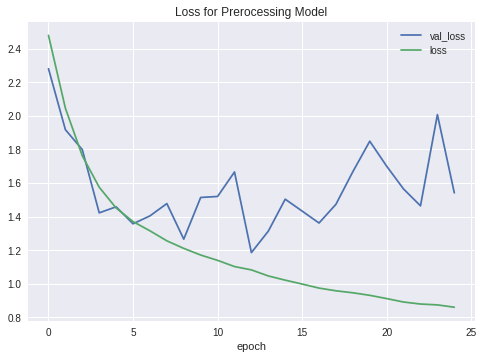

In [168]:
df = pd.read_csv('model_preprocessed_input/logs.csv')
p1 = df.plot(x = 'epoch', y = ['val_accuracy','accuracy'], title = 'Accuracy for Preprocessing Model')
p2 = df.plot(x = 'epoch', y = ['val_loss','loss'], title = 'Loss for Prerocessing Model')

fig = p1.get_figure()
fig.savefig("model_preprocessed_input/preprocess_acc.png")

fig = p1.get_figure()
fig.savefig("model_preprocessed_input/preprocess_loss.png")

p1
p2

#### Analysis of Preprocessing model
This model also suffers from **overfitting** which means that it will perform poorly on an unknown example. The only difference between two models is the scale for the loss plot which has decreased due to normalization of inputs. Despite normalization overfitting has not decreased. 

### Task 2.1 Pooling
Now, you need to modify the model by adding pooling layer(s). Pooling could be average pooling or max pooling. You can use the size and stride for pooling of your choice. 
<br> 
Modify the network by introducing pooling layer and train the model using the __fit_generator__ function. 

In [88]:
model_name = 'model_pooling'

input_img = Input(shape=(input_shape_cifar), name='input_img')
conv1 = Conv2D(8, kernel_size=(3, 3), strides = (2,2),  activation='relu')(input_img)
pooling = keras.layers.AveragePooling2D(pool_size=(2,2), padding='same')(conv1)
conv2 = Conv2D(16, (3, 3), strides = (2,2), activation='relu')(pooling)
flat = Flatten()(conv2)
dense1 = Dense(44, activation='relu')(flat)
output_class = Dense(10, activation='softmax')(dense1)


model_pooled = Model(inputs=input_img, outputs=output_class)

if not os.path.exists('./'+model_name):
    os.mkdir(model_name)

In [90]:
adam = Adam(lr=0.001)
model_pooled.compile(loss='categorical_crossentropy', 
              optimizer=adam, 
              metrics=['accuracy'])

In [91]:
#plot_model(model_pooled, model_name+'/'+model_name+'.png')
model_pooled.summary()

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_img (InputLayer)       (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 15, 15, 8)         224       
_________________________________________________________________
average_pooling2d_4 (Average (None, 8, 8, 8)           0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 3, 3, 16)          1168      
_________________________________________________________________
flatten_6 (Flatten)          (None, 144)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 44)                6380      
_________________________________________________________________
dense_12 (Dense)             (None, 10)                450

In [32]:
# Add the following callbacks: ModelCheckpoint, CSVLogger
checkpoint = ModelCheckpoint(model_name+'/'+model_name+'-{epoch:02d}-{val_loss:.2f}.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
csvlogger = CSVLogger(model_name+'/logs.csv', separator=',', append=True)
tensorboard = LRTensorBoard(log_dir='./'+model_name, histogram_freq=0, write_graph=True, write_grads=1, 
                            batch_size=batch_size, write_images=True)

callbacks = [checkpoint, csvlogger, tensorboard]

In [33]:
# Create generators
train_gen = data_generator(train_set, batch_size)
val_gen = data_generator(val_set, batch_size)
test_gen = data_generator(test_set, batch_size)

In [34]:
hist_pooled = model_pooled.fit_generator(train_gen, 
                    epochs=epochs, 
                    steps_per_epoch=len(Y_train)/batch_size, 
                    validation_data=val_gen, 
                    validation_steps=len(Y_val)/batch_size, 
                    callbacks=callbacks, 
                    verbose=1)
all_histories.append(hist_pooled)

Epoch 1/25
625/625 [==============================] - 34s 54ms/step - loss: 2.6691 - accuracy: 0.2472 - val_loss: 1.9009 - val_accuracy: 0.3326

Epoch 00001: val_loss improved from inf to 1.90086, saving model to model_pooling/model_pooling-01-1.90.h5
Epoch 2/25
625/625 [==============================] - 30s 47ms/step - loss: 1.7336 - accuracy: 0.3699 - val_loss: 1.6639 - val_accuracy: 0.3957

Epoch 00002: val_loss improved from 1.90086 to 1.66385, saving model to model_pooling/model_pooling-02-1.66.h5
Epoch 3/25
625/625 [==============================] - 38s 60ms/step - loss: 1.6395 - accuracy: 0.4034 - val_loss: 1.5898 - val_accuracy: 0.4139

Epoch 00003: val_loss improved from 1.66385 to 1.58984, saving model to model_pooling/model_pooling-03-1.59.h5
Epoch 4/25
625/625 [==============================] - 34s 54ms/step - loss: 1.5820 - accuracy: 0.4276 - val_loss: 1.4757 - val_accuracy: 0.4176

Epoch 00004: val_loss improved from 1.58984 to 1.47569, saving model to model_pooling/model

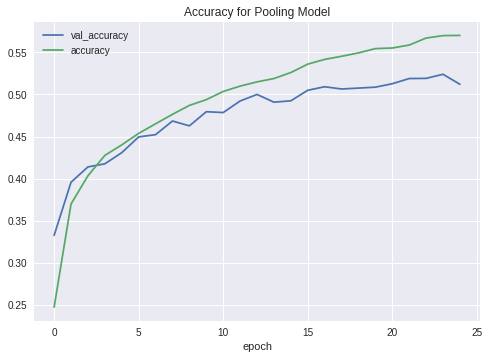

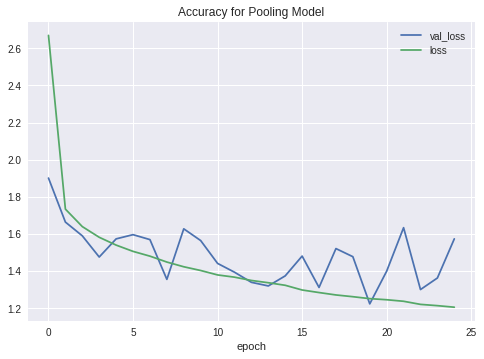

In [170]:
df = pd.read_csv('model_pooling/logs.csv')
p1 = df.plot(x = 'epoch', y = ['val_accuracy','accuracy'], title = 'Accuracy for Pooling Model')
p2 = df.plot(x = 'epoch', y = ['val_loss','loss'], title = 'Accuracy for Pooling Model')

fig = p1.get_figure()
fig.savefig("model_pooling/pooling_acc.png")

fig = p1.get_figure()
fig.savefig("model_pooling/pooling_loss.png")

p1
p2

#### Analysis of Pooling Model
In this model we add a pooling layer to the architecture. The choice was between max pooling and average pooling. I looked at the internet articles and youtube videos regarding whihc was the best but there was no black and white answer. From my researh i concluded that average pooling retains more information as compared to max pooling. Hence, an **average pooling layer** was added immediately after the first convolution layer. This helps in reducing the number of parameters in the model whihc speeds up the computation of a CNN. 

This model performs **better** than the previous two models as validation accuracy is closer the training accuracy. In addition, the validation loss is also closer to the training loss. Hence, the overfitting problem has been slightly resolved by using pooling layer

### Task 3.1 Dropout
Modify the network by introducing dropout layer(s) and train the model using the __fit_generator__ function. 

In [36]:
model_name = 'model_dropout'

input_img = Input(shape=(input_shape_cifar), name='input_img')

conv1 = Conv2D(8, kernel_size=(3, 3), strides = (2,2),  activation='relu')(input_img) # <- 1st convolutional layer
dropout1 = Dropout(0.2)(conv1) # <- 1st dropout layer
pooling1 = keras.layers.AveragePooling2D(pool_size=(2,2), padding='same')(dropout1) # <-

conv2 = Conv2D(16, (3, 3), strides = (2,2), activation='relu')(pooling1)
dropout2 = Dropout(0.2)(conv2)

flat = Flatten()(dropout2)
dense1 = Dense(44, activation='relu')(flat)
output_class = Dense(num_classes, activation='softmax')(dense1)

model_dropout = Model(inputs=input_img, outputs=output_class)

if not os.path.exists('./'+model_name):
    os.mkdir(model_name)

In [37]:
adam = Adam(lr=0.001)
model_dropout.compile(loss='categorical_crossentropy', 
              optimizer=adam, 
              metrics=['accuracy'])

In [38]:
#plot_model(model_dropout, model_name+'/'+model_name+'.png')
model_dropout.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_img (InputLayer)       (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 15, 15, 8)         224       
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 15, 8)         0         
_________________________________________________________________
average_pooling2d_2 (Average (None, 8, 8, 8)           0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 3, 3, 16)          1168      
_________________________________________________________________
dropout_2 (Dropout)          (None, 3, 3, 16)          0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 144)               0   

In [39]:
checkpoint = ModelCheckpoint(model_name+'/'+model_name+'-{epoch:02d}-{val_loss:.2f}.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
csvlogger = CSVLogger(model_name+'/logs.csv', separator=',', append=True)
tensorboard = LRTensorBoard(log_dir='./'+model_name, histogram_freq=0, write_graph=True, write_grads=1, 
                            batch_size=batch_size, write_images=True)

callbacks = [checkpoint,csvlogger, tensorboard]

In [40]:
# Create three Generators
train_gen = data_generator(train_set, batch_size)
val_gen = data_generator(val_set, batch_size)
test_gen = data_generator(test_set, batch_size)

In [41]:
hist_dropout = model_dropout.fit_generator(train_gen, 
                    epochs=epochs, 
                    steps_per_epoch=len(Y_train)/batch_size, 
                    validation_data=val_gen, 
                    validation_steps=len(Y_val)/batch_size, 
                    callbacks=callbacks, 
                    verbose=1)

all_histories.append(hist_dropout)

Epoch 1/25
625/625 [==============================] - 30s 48ms/step - loss: 3.2600 - accuracy: 0.1089 - val_loss: 2.2848 - val_accuracy: 0.1018

Epoch 00001: val_loss improved from inf to 2.28476, saving model to model_dropout/model_dropout-01-2.28.h5
Epoch 2/25
625/625 [==============================] - 29s 46ms/step - loss: 2.3026 - accuracy: 0.1064 - val_loss: 2.3008 - val_accuracy: 0.1033

Epoch 00002: val_loss did not improve from 2.28476
Epoch 3/25
625/625 [==============================] - 30s 47ms/step - loss: 2.2892 - accuracy: 0.1191 - val_loss: 2.2069 - val_accuracy: 0.1326

Epoch 00003: val_loss improved from 2.28476 to 2.20693, saving model to model_dropout/model_dropout-03-2.21.h5
Epoch 4/25
625/625 [==============================] - 34s 55ms/step - loss: 2.1994 - accuracy: 0.1784 - val_loss: 2.0191 - val_accuracy: 0.2530

Epoch 00004: val_loss improved from 2.20693 to 2.01909, saving model to model_dropout/model_dropout-04-2.02.h5
Epoch 5/25
625/625 [====================

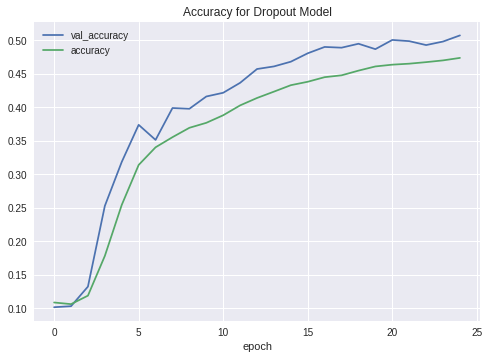

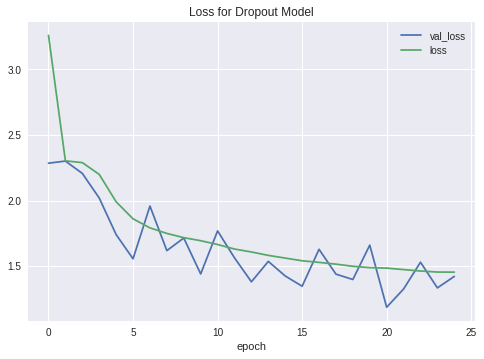

In [167]:
df = pd.read_csv('model_dropout/logs.csv')
p1 = df.plot(x = 'epoch', y = ['val_accuracy','accuracy'], title = 'Accuracy for Dropout Model')
p2 = df.plot(x = 'epoch', y = ['val_loss','loss'], title = 'Loss for Dropout Model')

fig = p1.get_figure()
fig.savefig("model_dropout/dropout_acc.png")

fig = p1.get_figure()
fig.savefig("model_dropout/dropout_loss.png")

p1
p2

#### Analysis of the Dropout model
This model introduces a dropout layer in the CNN. Dropout is used to prevecent the problem of overfitting by thinning out some layers which prevents overfitting on the training set. From the loss plot, we can see that the volatility in the validation loss plot has decreased which suggests that overfitting has reduced but the volatility continue to exist. 

### Task 4.1 Batch Normalization
Modify the network by introducing batch normalization layer(s) and train the model. 

In [43]:
model_name = 'model_batch_normalized'
if not os.path.exists('./'+model_name):
    os.mkdir(model_name)

In [44]:
input_img = Input(shape=(input_shape_cifar), name='input_img')

conv1 = Conv2D(8, kernel_size=(3, 3), strides = (2,2),  activation='relu')(input_img)
batchnorm1 = BatchNormalization()(conv1)
dropout1 = Dropout(0.3)(batchnorm1)
pooling1 = keras.layers.AveragePooling2D(pool_size=(2,2))(dropout1)
conv2 = Conv2D(16, (3, 3), strides = (2,2), activation='relu')(pooling1)
batchnorm2 = BatchNormalization()(conv2)
dropout3 = Dropout(0.2)(batchnorm2)
flat = Flatten()(dropout3)
dense = Dense(44, activation='relu')(flat)

output_class = Dense(num_classes, activation='softmax')(dense)


model_normalized = Model(inputs=input_img, outputs=output_class)

In [45]:
adam = Adam(lr=0.001)
model_normalized.compile(loss='categorical_crossentropy', 
              optimizer=adam, 
              metrics=['accuracy'])

In [46]:
#plot_model(model_normalized, model_name+'/'+model_name+'.png')
model_normalized.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_img (InputLayer)       (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 15, 15, 8)         224       
_________________________________________________________________
batch_normalization_1 (Batch (None, 15, 15, 8)         32        
_________________________________________________________________
dropout_3 (Dropout)          (None, 15, 15, 8)         0         
_________________________________________________________________
average_pooling2d_3 (Average (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 3, 3, 16)          1168      
_________________________________________________________________
batch_normalization_2 (Batch (None, 3, 3, 16)          64  

In [47]:
# Add the following checkpoints: ModelCheckpoint, CSVLogger
checkpoint = ModelCheckpoint(model_name+'/'+model_name+'-{epoch:02d}-{val_loss:.2f}.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
cvslogger = CSVLogger(model_name+'/logs.csv', separator=',', append=True)
tensorboard = LRTensorBoard(log_dir='./'+model_name, histogram_freq=0, write_graph=True, write_grads=1, 
                            batch_size=batch_size, write_images=True)

callbacks = [checkpoint,cvslogger,tensorboard]

In [48]:
# Create three generators
train_gen = data_generator(train_set, batch_size)
val_gen = data_generator(val_set, batch_size)
test_gen = data_generator(test_set, batch_size)

In [49]:
hist_normalized = model_normalized.fit_generator(train_gen, 
                    epochs=epochs, 
                    steps_per_epoch=len(Y_train)/batch_size, 
                    validation_data=val_gen, 
                    validation_steps=len(Y_val)/batch_size, 
                    callbacks=callbacks, 
                    verbose=1)
all_histories.append(hist_normalized)

Epoch 1/25
625/625 [==============================] - 38s 60ms/step - loss: 1.8968 - accuracy: 0.3208 - val_loss: 1.5785 - val_accuracy: 0.4266

Epoch 00001: val_loss improved from inf to 1.57854, saving model to model_batch_normalized/model_batch_normalized-01-1.58.h5
Epoch 2/25
625/625 [==============================] - 31s 50ms/step - loss: 1.5670 - accuracy: 0.4293 - val_loss: 1.5473 - val_accuracy: 0.4682

Epoch 00002: val_loss improved from 1.57854 to 1.54731, saving model to model_batch_normalized/model_batch_normalized-02-1.55.h5
Epoch 3/25
625/625 [==============================] - 31s 50ms/step - loss: 1.4802 - accuracy: 0.4642 - val_loss: 1.5462 - val_accuracy: 0.4227

Epoch 00003: val_loss improved from 1.54731 to 1.54622, saving model to model_batch_normalized/model_batch_normalized-03-1.55.h5
Epoch 4/25
625/625 [==============================] - 31s 49ms/step - loss: 1.4302 - accuracy: 0.4830 - val_loss: 1.2992 - val_accuracy: 0.5192

Epoch 00004: val_loss improved from 1

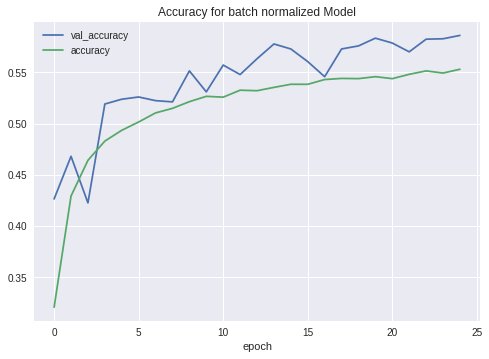

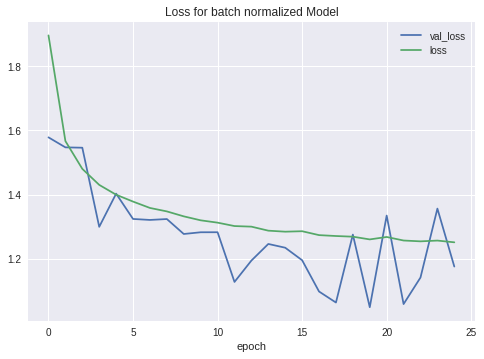

In [171]:
df = pd.read_csv('model_batch_normalized/logs.csv')
p1 = df.plot(x = 'epoch', y = ['val_accuracy','accuracy'], title = 'Accuracy for batch normalized Model')
p2 = df.plot(x = 'epoch', y = ['val_loss','loss'], title = 'Loss for batch normalized Model')

fig = p1.get_figure()
fig.savefig("model_batch_normalized/bachnorm_acc.png")

fig = p1.get_figure()
fig.savefig("model_batch_normalized/batchnorm_loss.png")

p1
p2

#### Analysis of Batch Normalization
This model uses batch normalization layer in which a particular batch is normalized or in other words mean centered. This helps in speeding up the training process and reduces the number of epochs required to converge. From the accuracy plot above, we see a reduced gap between the accuracy on training set and validation set. The loss validation loss is lower than training loss, which means that the model is not overfitting. Despite this, we see that there is still volatility in the validation loss.

### Task 5.1 Comparison of all models
In this task you need to plot the loss and accuracy for all models and __discuss__ which model has better performance and why do you think so.

In [1]:
# Plot accuracy of all models
def plotHistory(histories, names, metric):
    plt.clf() 
    x_axis = list(range(epochs))
    for hist, name in zip(histories, names):
        plt.plot(x_axis, hist.history[metric], label=metric+'_'+name)
        plt.scatter(x_axis, hist.history[metric])
    plt.legend()
    plt.title(metric)
    plt.show()

In [54]:
names = ['base_model','model_pooling', 'model_dropout', 'model_batch_normalized']

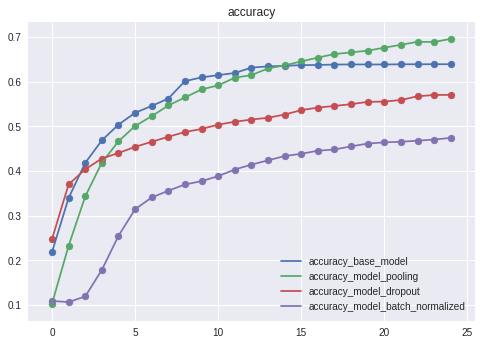

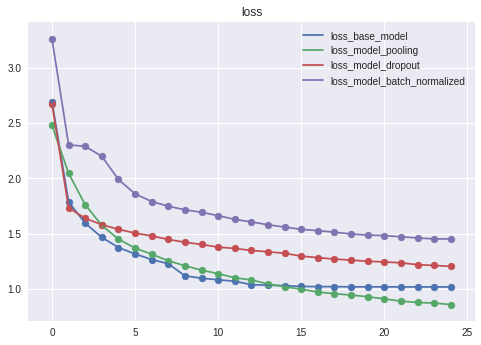

In [57]:
plotHistory(all_histories,names = names,metric = 'accuracy')
plotHistory(all_histories,names = names,metric = 'loss')

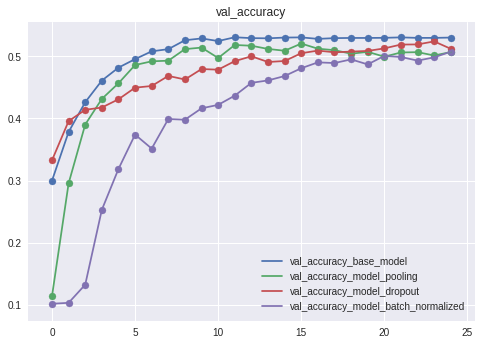

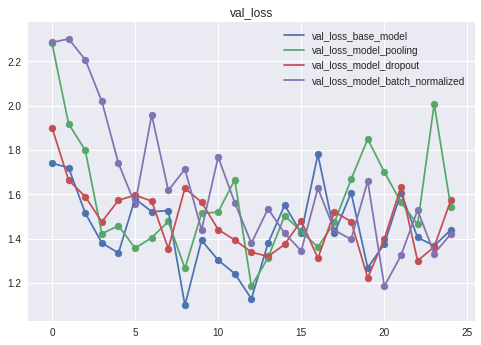

In [58]:
plotHistory(all_histories,names = names,metric = 'val_accuracy')
plotHistory(all_histories,names = names,metric = 'val_loss')

#### Comparing all models
There are different criterias for selecting the best model.  
1. Overfitting issue
2. Number of epochs required to converge  
3. Validation and train loss  

Based on these criterias and above created plots for accuracy and loss, I selected the Pooling model as the best model. Firstly, it has the best accuracy on the training set. Though it does not have the best validation accuracy, it doese not overfits. Secondly, it does not takes a lot of epochs to converge, which can help in solving computationaly expensive probles efficiently. Validation loss is still a lot volatile but it holds true for all models. 

Thus, my best model is **Pooling Model**. 

#### Tensorboard 
We will be covering Tensorboard in Friday's tutorial. You can complete this part after the tutorial (21st Feb 2020)

You can run TensorBoard using the following command
```tensorboard --logdir=path/to/log-directory
```
Now for logs of all above trained models, take snapshot of the _loss_ and _accuracy_ plots and save in the directory where this notebook is. To show that saved plot here in notebook use following command in _markdown_ cell. 
<br> __![](path_to_image)__

**Add cells to include loss plots**

##### Add your analysis here

### Task 5.2 Visualize Activations
We will be covering this in Friday's tutorial. You can complete this part after the tutorial (21st Feb 2020). In this task, you are required to visualize the activations (outputs) of both the convolution layers of a model.

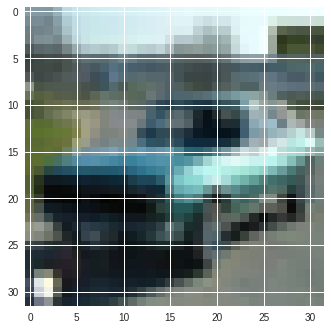

In [75]:
# Load any image here
path = test_set.iloc[1000,0]
test_image = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)

plt.imshow(test_image)

In [78]:
#plt.gca().grid(False);

test_reshaped = test_image.reshape((1,32,32,3))
# Get a prediction from ANY ONE of your models and output its label
print('Predicted label : ' , model_pooled.predict(test_reshaped).argmax(axis=1)[0])

Predicted label :  1


In [121]:
# Create a Model from the Input layer to a Convolutional Layer
new_model_1 = Model(inputs=input_img, 
                  outputs=model_pooled.get_layer('conv2d_11').output)

In [122]:
# Get a prediction for your chosen image using this model
predicted_activations = new_model_1.predict(test_reshaped)

In [123]:
predicted_activations.shape

(1, 15, 15, 8)

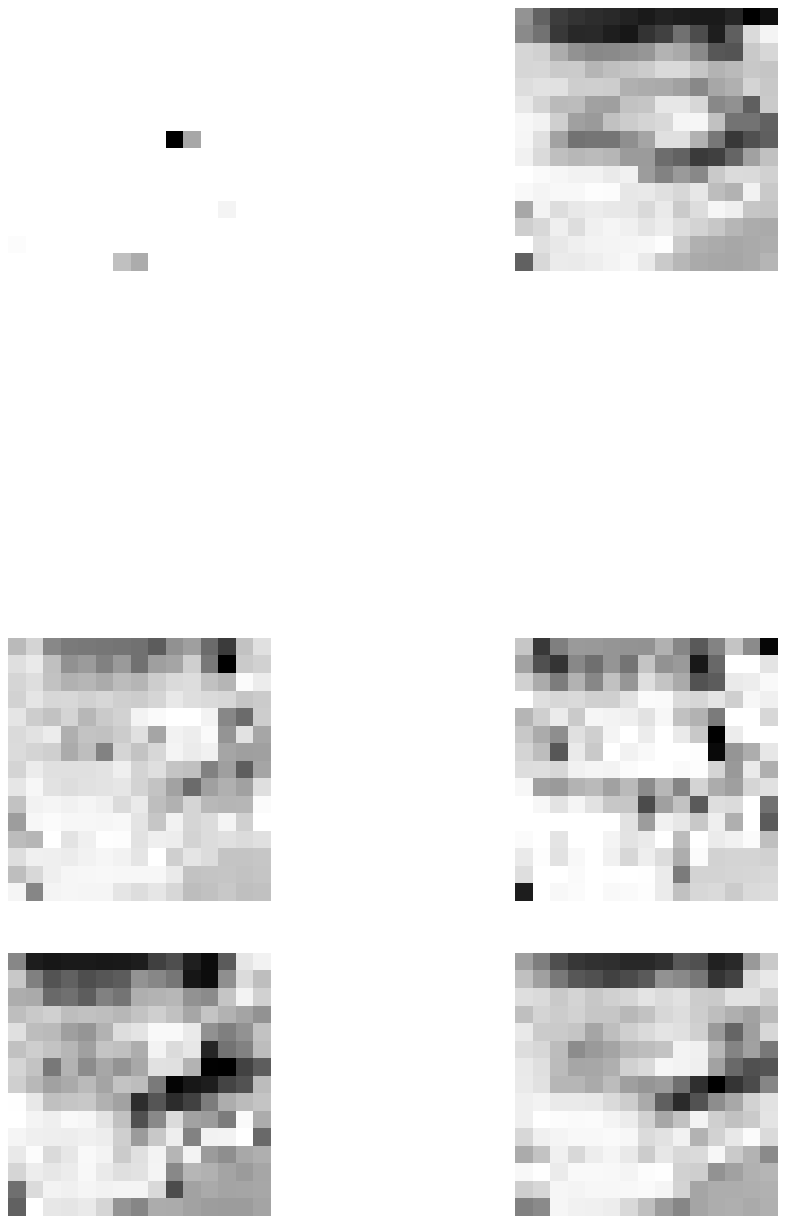

In [124]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15,20), dpi=80)
for i,ax in enumerate(axes.flatten()):
    ax.imshow(predicted_activations[0,:,:,i]);
    ax.grid(False);
    ax.axis('off');

In [125]:
# Create another model to visualize activations from ANOTHER convolutional layer
new_model_2 = Model(inputs=input_img, 
                  outputs=model_pooled.get_layer('conv2d_12').output)

In [126]:
# You may rename this variable
second_predicted_activations = new_model_2.predict(test_reshaped)

In [127]:
second_predicted_activations.shape

(1, 3, 3, 16)

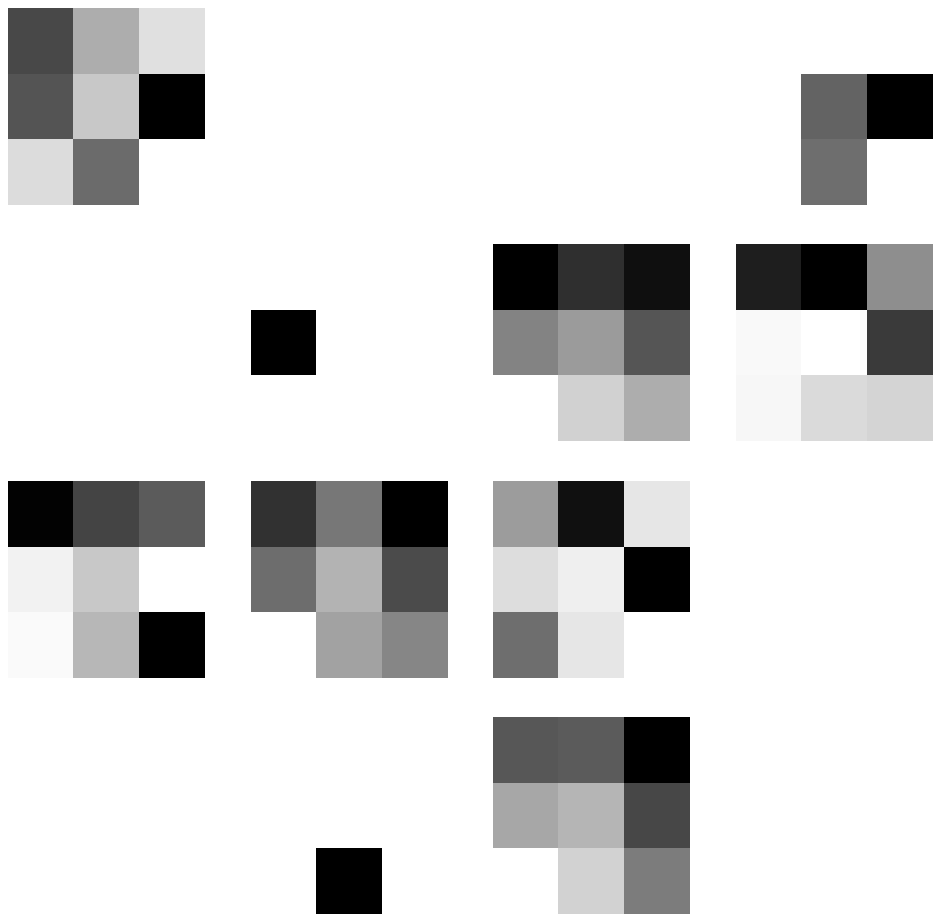

In [128]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(15,15), dpi=80)
for i,ax in enumerate(axes.flatten()):
    ax.imshow(second_predicted_activations[0,:,:,i]);
    ax.grid(False);
    ax.axis('off');

Q) What features from your chosen image do you think your model has been able to learn? In terms of filters (weights), what goes on when we add more convolutional layers in our models?

### Task 6.1  Effect of learning rate
Take the best selected model in __Task 5.1__ and change its learning rate to: 
- 6.1.1 any value between 5 and 1.
- 6.1.2 learning rate = any value between 0.6 and  0.1 
- 6.1.3 learning rate = 0.00001

and train these three models to compare the effect learning rate.

In [144]:
# Use code provided in previous tasks
lr_histories = []

#### 6.1.1 any value between 5 and 1.

In [145]:
model_name = 'model_6.1.1'

adam = Adam(lr=3)
model_pooled.compile(loss='categorical_crossentropy', 
              optimizer=adam, 
              metrics=['accuracy'])

if not os.path.exists('./'+model_name):
    os.mkdir(model_name)
    
checkpoint = ModelCheckpoint(model_name+'/'+model_name+'-{epoch:02d}-{val_loss:.2f}.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
csvlogger = CSVLogger(model_name+'/logs.csv', separator=',', append=True)
tensorboard = LRTensorBoard(log_dir='./'+model_name, histogram_freq=0, write_graph=True, write_grads=1, 
                            batch_size=batch_size, write_images=True)

callbacks = [checkpoint, csvlogger, tensorboard]

train_gen = data_generator(train_set, batch_size)
val_gen = data_generator(val_set, batch_size)
test_gen = data_generator(test_set, batch_size)

In [146]:
hist_lr_1 = model_pooled.fit_generator(train_gen, 
                    epochs=epochs, 
                    steps_per_epoch=len(Y_train)/batch_size, 
                    validation_data=val_gen, 
                    validation_steps=len(Y_val)/batch_size, 
                    callbacks=callbacks, 
                    verbose=1)
lr_histories.append(hist_lr_1)

Epoch 1/25
625/625 [==============================] - 34s 55ms/step - loss: 2.4869 - accuracy: 0.1032 - val_loss: 2.3522 - val_accuracy: 0.1001

Epoch 00001: val_loss improved from inf to 2.35224, saving model to model_6.1.1/model_6.1.1-01-2.35.h5
Epoch 2/25
625/625 [==============================] - 34s 55ms/step - loss: 2.4991 - accuracy: 0.1023 - val_loss: 2.5106 - val_accuracy: 0.0985

Epoch 00002: val_loss did not improve from 2.35224
Epoch 3/25
625/625 [==============================] - 35s 56ms/step - loss: 2.4839 - accuracy: 0.1018 - val_loss: 2.3712 - val_accuracy: 0.1047

Epoch 00003: val_loss did not improve from 2.35224
Epoch 4/25
625/625 [==============================] - 29s 47ms/step - loss: 2.4937 - accuracy: 0.0992 - val_loss: 2.6737 - val_accuracy: 0.1017

Epoch 00004: val_loss did not improve from 2.35224
Epoch 5/25
625/625 [==============================] - 30s 48ms/step - loss: 2.4919 - accuracy: 0.0977 - val_loss: 2.5340 - val_accuracy: 0.0994

Epoch 00005: val_lo

#### 6.1.2 learning rate = any value between 0.6 and 0.1

In [148]:
model_name = 'model_6.1.2'

adam = Adam(lr=0.3)
model_pooled.compile(loss='categorical_crossentropy', 
              optimizer=adam, 
              metrics=['accuracy'])

if not os.path.exists('./'+model_name):
    os.mkdir(model_name)
    
checkpoint = ModelCheckpoint(model_name+'/'+model_name+'-{epoch:02d}-{val_loss:.2f}.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
csvlogger = CSVLogger(model_name+'/logs.csv', separator=',', append=True)
tensorboard = LRTensorBoard(log_dir='./'+model_name, histogram_freq=0, write_graph=True, write_grads=1, 
                            batch_size=batch_size, write_images=True)

callbacks = [checkpoint, csvlogger, tensorboard]

train_gen = data_generator(train_set, batch_size)
val_gen = data_generator(val_set, batch_size)
test_gen = data_generator(test_set, batch_size)

In [149]:
hist_lr_2 = model_pooled.fit_generator(train_gen, 
                    epochs=epochs, 
                    steps_per_epoch=len(Y_train)/batch_size, 
                    validation_data=val_gen, 
                    validation_steps=len(Y_val)/batch_size, 
                    callbacks=callbacks, 
                    verbose=1)
lr_histories.append(hist_lr_2)

Epoch 1/25
625/625 [==============================] - 30s 47ms/step - loss: 2.3274 - accuracy: 0.0992 - val_loss: 2.3032 - val_accuracy: 0.1023

Epoch 00001: val_loss improved from inf to 2.30325, saving model to model_6.1.2/model_6.1.2-01-2.30.h5
Epoch 2/25
625/625 [==============================] - 29s 46ms/step - loss: 2.3299 - accuracy: 0.1004 - val_loss: 2.2702 - val_accuracy: 0.0997

Epoch 00002: val_loss improved from 2.30325 to 2.27015, saving model to model_6.1.2/model_6.1.2-02-2.27.h5
Epoch 3/25
625/625 [==============================] - 29s 46ms/step - loss: 2.3289 - accuracy: 0.1001 - val_loss: 2.3425 - val_accuracy: 0.0981

Epoch 00003: val_loss did not improve from 2.27015
Epoch 4/25
625/625 [==============================] - 30s 47ms/step - loss: 2.3260 - accuracy: 0.1005 - val_loss: 2.3092 - val_accuracy: 0.0984

Epoch 00004: val_loss did not improve from 2.27015
Epoch 5/25
625/625 [==============================] - 29s 47ms/step - loss: 2.3257 - accuracy: 0.1025 - val_

#### 6.1.3 learning rate = 0.00001

In [151]:
model_name = 'model_6.1.3'

adam = Adam(lr=0.00001)
model_pooled.compile(loss='categorical_crossentropy', 
              optimizer=adam, 
              metrics=['accuracy'])

if not os.path.exists('./'+model_name):
    os.mkdir(model_name)
    
checkpoint = ModelCheckpoint(model_name+'/'+model_name+'-{epoch:02d}-{val_loss:.2f}.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
csvlogger = CSVLogger(model_name+'/logs.csv', separator=',', append=True)
tensorboard = LRTensorBoard(log_dir='./'+model_name, histogram_freq=0, write_graph=True, write_grads=1, 
                            batch_size=batch_size, write_images=True)

callbacks = [checkpoint, csvlogger, tensorboard]

train_gen = data_generator(train_set, batch_size)
val_gen = data_generator(val_set, batch_size)
test_gen = data_generator(test_set, batch_size)

In [152]:
hist_lr_2 = model_pooled.fit_generator(train_gen, 
                    epochs=epochs, 
                    steps_per_epoch=len(Y_train)/batch_size, 
                    validation_data=val_gen, 
                    validation_steps=len(Y_val)/batch_size, 
                    callbacks=callbacks, 
                    verbose=1)
lr_histories.append(hist_lr_2)

Epoch 1/25
625/625 [==============================] - 29s 47ms/step - loss: 2.3144 - accuracy: 0.0995 - val_loss: 2.3153 - val_accuracy: 0.1016

Epoch 00001: val_loss improved from inf to 2.31529, saving model to model_6.1.3/model_6.1.3-01-2.32.h5
Epoch 2/25
625/625 [==============================] - 29s 47ms/step - loss: 2.3141 - accuracy: 0.0995 - val_loss: 2.3315 - val_accuracy: 0.1010

Epoch 00002: val_loss did not improve from 2.31529
Epoch 3/25
625/625 [==============================] - 30s 48ms/step - loss: 2.3137 - accuracy: 0.0995 - val_loss: 2.3040 - val_accuracy: 0.1024

Epoch 00003: val_loss improved from 2.31529 to 2.30403, saving model to model_6.1.3/model_6.1.3-03-2.30.h5
Epoch 4/25
625/625 [==============================] - 30s 47ms/step - loss: 2.3134 - accuracy: 0.0995 - val_loss: 2.3079 - val_accuracy: 0.1005

Epoch 00004: val_loss did not improve from 2.30403
Epoch 5/25
625/625 [==============================] - 30s 47ms/step - loss: 2.3131 - accuracy: 0.0995 - val_

### Task 6.2 Plot loss and accuracy
Plot the loss and accracy for best model selected in task 5.1, and model trained in 6.1.1, 6.1.2 and 6.1.3 task. Give the detailed analysis of the effect of learning rate in your words and select the best learning rate for this problem.

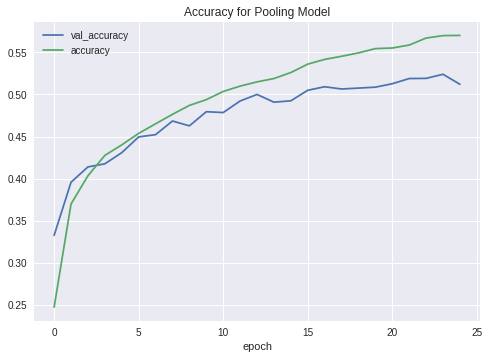

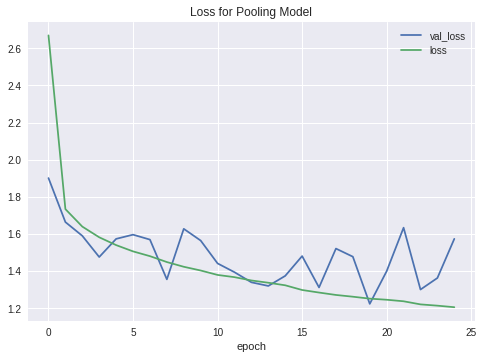

In [172]:
df = pd.read_csv('model_pooling/logs.csv')
df.plot(x = 'epoch', y = ['val_accuracy','accuracy'], title = 'Accuracy for Pooling Model')
df.plot(x = 'epoch', y = ['val_loss','loss'], title = 'Loss for Pooling Model')

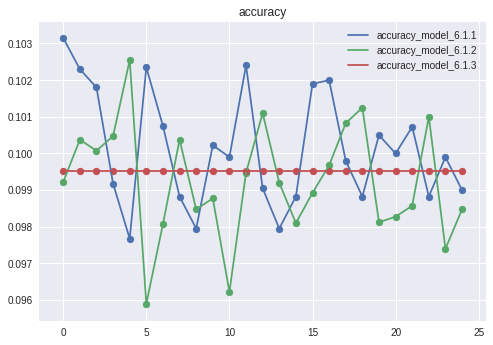

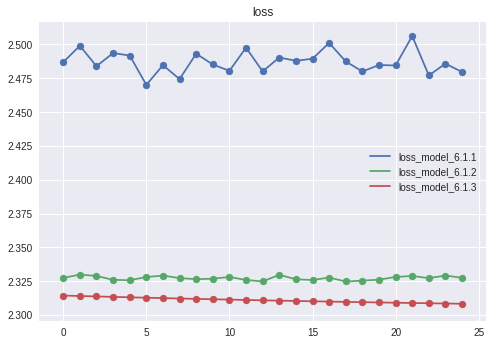

In [173]:
# Use plotHistory to make these plots
names2 = ['model_6.1.1','model_6.1.2','model_6.1.3']
plotHistory(lr_histories,names = names2, metric = 'accuracy')
plotHistory(lr_histories,names = names2, metric = 'loss')

Analysis:

#### Model 6.1.1 (lr = 3) 
This model uses a very high learning rate. Hence, it can cause our model to fail to converge to a minimum. Due to which the loss of the model is significantly **higher** than the other models. The accuracy is also very **volatile** which shows that the model fails to converge. The problem of overshooting also exsists where our gradient descent will take larger steps in each epoch and may never reach minima.


#### Model 6.1.2 (lr = 0.3)  
This model uses an intermediate value for learning rate. The loss is lower than the previous model but the accuracy is still volatile which means that the model fails to converge in the given epochs.


#### Model 6.1.3 (lr = 0.00001)  
This model uses the lowest learning rate. Since, it is very low, the model takes very small steps in gradient descent. Hence, the model's accuracy and loss are relatively constant over the given number of epochs. This suggests that the model will take a **lot of time to converge**. Another problem that exists with this is that it may stuck in a local minima and may not ever come out of it since it is taking very small steps. 

#### Conclusion
Based on the above trials with different learning rates i conclude that the best learning rate for this particcular problem was was 0.001. Having said that this is not true for all models and there is no fixed value for all problems. 